## Research title: 
## Authors:
### Vladimir Milchev
### Kristofar Stavrev
### Radoslava Dencheva
### Stoyan Stoyanov




## 1.Import all necessary libraries

In [26]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob 
from statsmodels import api as sm
from scipy.stats import linregress
import matplotlib.pyplot as plt
#conda install yahoofinancials
from yahoofinancials import YahooFinancials

In [27]:
"""Constants"""
TICKER_BTC = "BTC-USD"
TICKER_NASDAQ = "^IXIC"
TICKER_SNP = "^GSPC"
START_DATE = "2014-09-17"
END_DATE = datetime.now().strftime('%Y-%m-%d')
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 100)

## 2. Data Collection

### Get data for BTC

In [28]:
btc_financials = YahooFinancials(TICKER_BTC)
data=btc_financials.get_historical_price_data(START_DATE, END_DATE, "daily")
btc_df = pd.DataFrame(data[TICKER_BTC]['prices'])

### Get data for S&P 500

In [29]:
snp_financials = YahooFinancials(TICKER_SNP)
data=snp_financials.get_historical_price_data(START_DATE, END_DATE, "daily")
snp_df = pd.DataFrame(data[TICKER_SNP]['prices'])

## Data preparation

In [30]:
#Put all unecessarry columns in an array
to_drop = ['high', 'low', 'open', 'volume', 'adjclose', 
       'formatted_date']

### Prepare BTC data

In [31]:
#rename close column to price
btc_df = btc_df.rename(columns = {"close":"BTC"})

#check for date duplicates
len(btc_df['formatted_date'].unique()) #2759
len(btc_df.index) #2759

#drop unecessary columns, create date column and set as index
btc_df.date = pd.to_datetime(btc_df.formatted_date)
btc_df = btc_df.drop(to_drop, axis=1).set_index("date")

#Remove duplicated indexes/dates for BTC
if btc_df.index.duplicated().any():
    btc_df = btc_df.loc[~btc_df.index.duplicated(), :]

btc_df.head(10)

,BTC
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
2014-09-22,402.152008
2014-09-23,435.790985
2014-09-24,423.204987
2014-09-25,411.574005


### Prepare S&P 500 data

In [32]:
#rename close column to price
snp_df = snp_df.rename(columns = {"close":"SP500"})

#check for date duplicates
len(snp_df['formatted_date'].unique()) #1902
len(snp_df.index) #1902

#drop unecessary columns, create date column and set as index
snp_df.date = pd.to_datetime(snp_df.formatted_date)
snp_df = snp_df.drop(to_drop, axis=1).set_index("date")

#Remove duplicated indexes/dates for BTC
if snp_df.index.duplicated().any():
    snp_df = snp_df.loc[~snp_df.index.duplicated(), :]

snp_df.head(10)

,SP500
date,
2014-09-17,2001.569946
2014-09-18,2011.359985
2014-09-19,2010.400024
2014-09-22,1994.290039
2014-09-23,1982.770020
2014-09-24,1998.300049
2014-09-25,1965.989990
2014-09-26,1982.849976
2014-09-29,1977.800049


### Merge both dataframes into one

In [33]:
#Data frame with NaN values that is going to be used for imputation and modelling
df = btc_df.merge(snp_df, how="outer", left_index=True, right_index=True)

#Reindex to get all dates
df.reindex(pd.date_range(start=min(df.index), end=max(df.index), freq='D'))

#using forward propagation to fill all missing date values for SNP500
df.fillna(method='ffill', inplace=True)


In [9]:
df.head(100)

,BTC,SP500
date,,
2014-09-17,457.334015,2001.569946
2014-09-18,424.440002,2011.359985
2014-09-19,394.795990,2010.400024
2014-09-20,408.903992,2010.400024
2014-09-21,398.821014,2010.400024
2014-09-22,402.152008,1994.290039
2014-09-23,435.790985,1982.770020
2014-09-24,423.204987,1998.300049
2014-09-25,411.574005,1965.989990


## Exploratory data analysis for Bitcoin and S&P 500 prices
For the exploratory analysis we are going to use the dataframe that has no missing values

### Correlation

In [10]:
correlation = df.corr()
correlation

,BTC,SP500
BTC,1.000000,0.914553
SP500,0.914553,1.000000


By looking into our results, we see that we have a strong and positive correlation of 0.91 between the price of Bitcoin and S&P 500. That means that when the prices of the stock market go up, we can expect Bitcoin to follow the trend and also move up.

(0.14287205102755146,
 0.9688691746567483,
 27,
 2732,
 {'1%': -3.4327458473129906,
  '5%': -2.86259851213211,
  '10%': -2.5673334803017864},
 25624.271749365154)

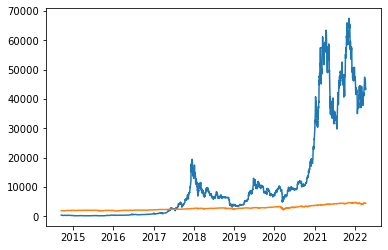

In [11]:
#Checking if the correlation is statistically significant by performing Pearson Correlation test

from scipy.stats.stats import pearsonr

pearsonr(df["BTC"], df["SP500"]) # p value 0.0 , corr coeff: 0.91
#Since the correlation coefficient is close to 1, this tells us that there is a strong positive association between the two variables.
#And since the corresponding p-value is less than .05, we conclude that there is a statistically significant association between the two variables

#check data for stationarity with Dickey Fuller test
#pip install statsmodels
from statsmodels.tsa.stattools import adfuller
plt.plot('BTC',data=df)
plt.plot('SP500',data=df)
adfuller(df["BTC"]) # p value 0.76
adfuller(df["SP500"]) # p value 0.96
#Since the p-value is not less than .05, we fail to reject the null hypothesis.
#Data is not stationary therefore we need to normalize it


### Visualize correlation

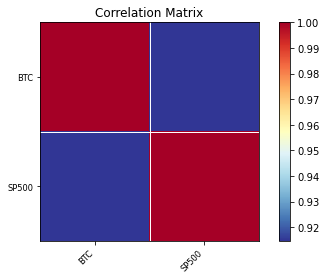

In [12]:
sm.graphics.plot_corr(correlation,xnames=list(correlation.columns))
plt.show()

The red colour of the graph means that the relationship is strong and positive.

### Linear regression

#### Are SP500 and BTC Statistilcally significant?
#### H0: BTC and Stock prices are not related

In [13]:

linregress(df.SP500,df.BTC)


LinregressResult(slope=19.134035426604182, intercept=-42647.03688968596, rvalue=0.9145525452842918, pvalue=0.0, stderr=0.161132813555918, intercept_stderr=476.062199185865)

#### Since our p-value is lower than 0.05 we can reject H0, and therefore, we can statistically say that Bitcoin and stock prices are moving together.

### Visualizing The Closing  Price of both the stocks

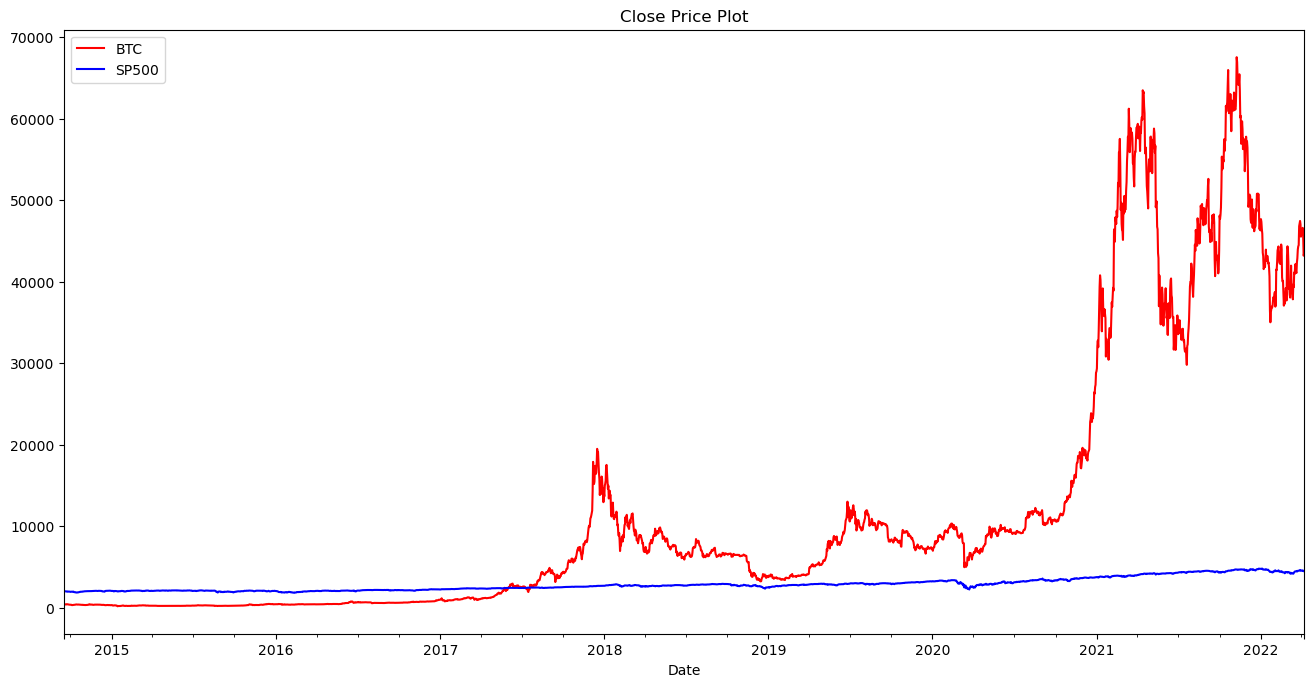

In [14]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=100)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
df.BTC.plot(label='BTC', color='red')
df.SP500.plot(label='SP500', color='blue')
  
# adding title to the plot
plt.title('Close Price Plot')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

In [15]:
df.columns

Index(['BTC', 'SP500'], dtype='object')

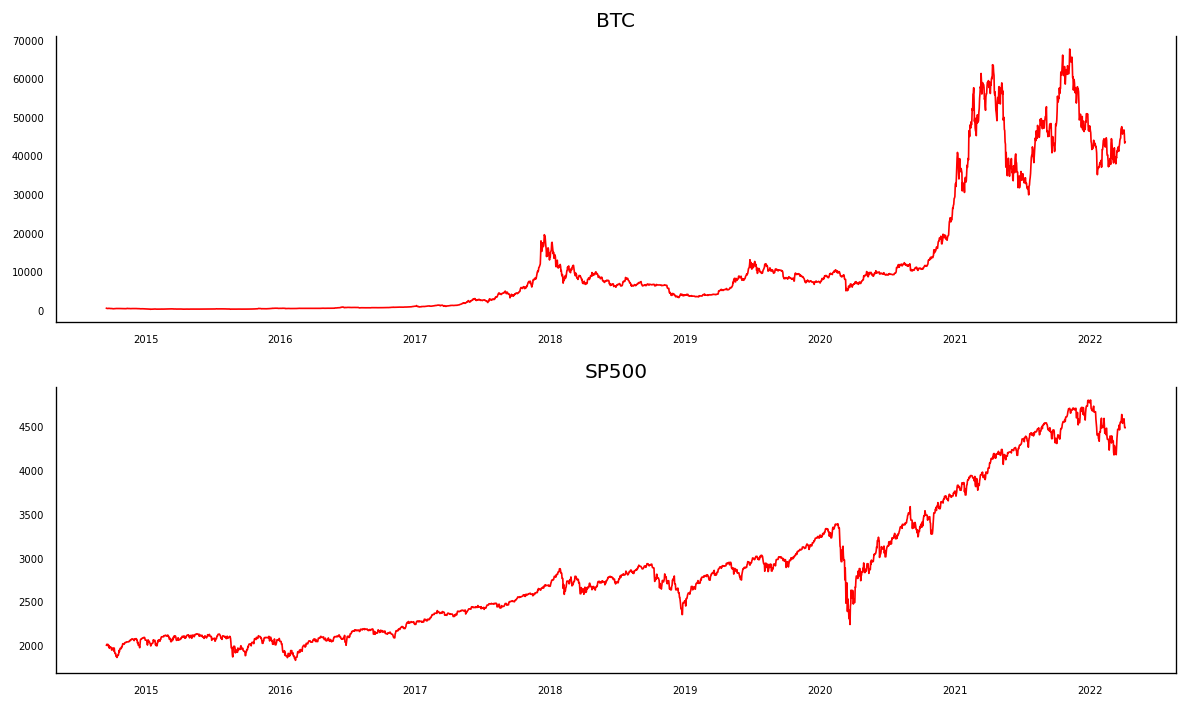

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

Here, we can see different trends for our variables. It would be helpful if we established whether or not our time series followed a normal (or Gaussian) distribution. We will do this based on the test for normality based on the Jarque-Bera test.

### Jarque-Bera Test
Below we will make a Jarque-Bera test to check if the datasets are normally distributed. Here we are going to use the initial dataframes for each of the prices 

In [17]:
# imports the necessary module for statistics
from scipy import stats

# unpacks the test statistic and p-value from the normaltest of gold
stat, p = stats.normaltest(df.BTC)

# prints both the test statistic and p-value
print('Statistics=%.3f, p=%.3f' % (stat, p))

# chooses an alpha of 0.05 and assigns to variable 'alpha'
alpha = 0.05

# creates an if statement for the hypothesis using the p-value test
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=799.143, p=0.000
Data does not look Gaussian (reject H0)


In [18]:
# imports the necessary module for statistics
from scipy import stats

# unpacks the test statistic and p-value from the normaltest of gold
stat, p = stats.normaltest(df.SP500)

# prints both the test statistic and p-value
print('Statistics=%.3f, p=%.3f' % (stat, p))

# chooses an alpha of 0.05 and assigns to variable 'alpha'
alpha = 0.05

# creates an if statement for the hypothesis using the p-value test
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=288.430, p=0.000
Data does not look Gaussian (reject H0)


As we can see, we recieve a p-value and a test statistic in return. While we don't have a Chi-Square chart to determine the critical region, we do have a p-value, which is basically zero.

A p-value less than 0.05 basically means our test statistic falls within the critical region (inside the tail); therefore, we can reject the null hypothesis. The dataset is not normally distributed, which we probably could have assumed by looking at the time series plots from before.

Next, we can look for a fat-tail distribution and asymmetry by looking for kurtosis and skewness.

In [19]:
print('Kurtosis of normal distribution for BTC: {}'.format(stats.kurtosis(df.BTC)))
print('Skewness of normal distribution for BTC: {}'.format(stats.skew(df.BTC)))

Kurtosis of normal distribution for BTC: 1.717363841963774
Skewness of normal distribution for BTC: 1.724433158586007


In [20]:
print('Kurtosis of normal distribution for S&P500: {}'.format(stats.kurtosis(df.SP500)))
print('Skewness of normal distribution for S&P500: {}'.format(stats.skew(df.SP500)))

Kurtosis of normal distribution for S&P500: -0.2104404395456836
Skewness of normal distribution for S&P500: 0.9051328901789177


These two distributions can provide us with some intuition about the distribution of our data. A value close to 0 for kurtosis indicates a normal distribution where asymmetrical nature is signified by a value between -0.5 and +0.5 for skewness. The tails are heavier for kurtosis greater than 0 and vice versa. Moderate skewness refers to the value between -1 and -0.5 or 0.5 and 1.

We can also use a normal probability plot to assess the probability distribution of a randomly selected variable inside of our dataset

count     2760.000000
mean     11843.780231
std      16458.994312
min        178.102997
25%        610.121490
50%       6396.625000
75%      10818.298096
max      67566.828125
Name: BTC, dtype: float64

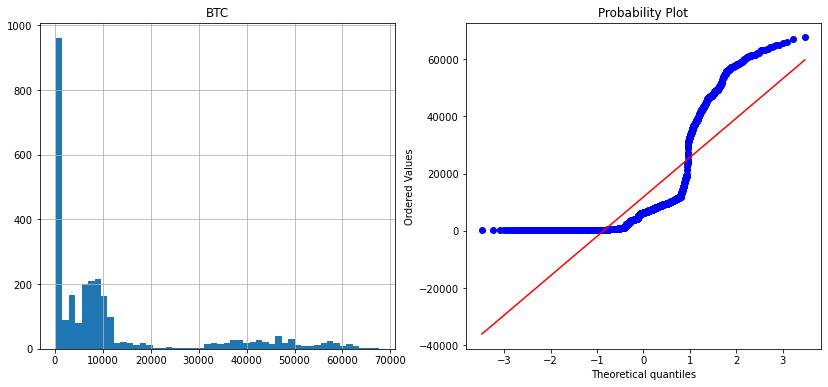

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df.BTC.hist(bins=50)
plt.title('BTC')
plt.subplot(1,2,2)
stats.probplot(btc_df.BTC, plot=plt);
btc_df.BTC.describe().T

count    1903.000000
mean     2848.042621
std       786.862490
min      1829.079956
25%      2139.494995
50%      2709.800049
75%      3222.334961
max      4796.560059
Name: SP500, dtype: float64

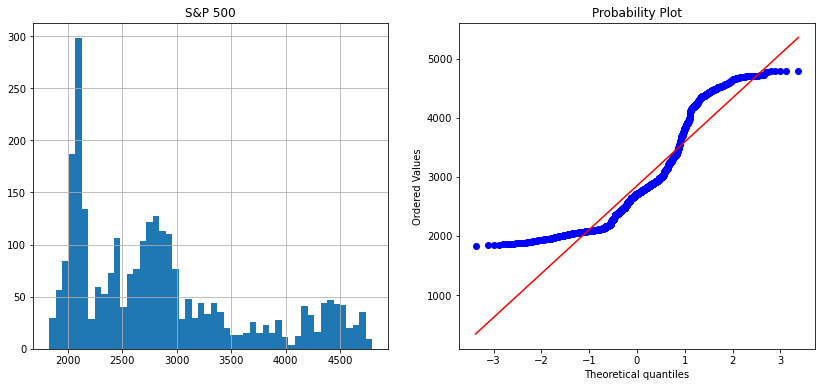

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df.SP500.hist(bins=50)
plt.title('S&P 500')
plt.subplot(1,2,2)
stats.probplot(snp_df.SP500, plot=plt);
snp_df.SP500.describe().T

# TODO 
### Dickey-Fuller Test for stationarity on the whole dataset

### Split dataset into train and test sets
In order for us to process further, we would need to transform our time series into a stationary time series. However, before we do this, we are going to take the opportunity to seperate our time series into a testing set and a training set. We will do this to assess the predictive capabilities of the model we will eventually create

In [23]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(df, train_size=0.75,shuffle = False)
print(len(train_dataset) / len(df))

0.75


In [24]:
train_dataset.sort_index()

,BTC,SP500
date,,
2014-09-17,457.334015,2001.569946
2014-09-18,424.440002,2011.359985
2014-09-19,394.795990,2010.400024
2014-09-20,408.903992,2010.400024
2014-09-21,398.821014,2010.400024
...,...,...
2020-05-13,9269.987305,2820.000000
2020-05-14,9733.721680,2852.500000
2020-05-15,9328.197266,2863.699951


(-1.6972897845224713,
 0.43250939965199536,
 24,
 2045,
 {'1%': -3.4335517248444334,
  '5%': -2.8629543667432555,
  '10%': -2.567522945522803},
 18641.941841669384)

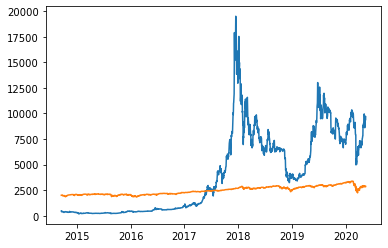

In [25]:
#Dickey Fuller test for the train data set
plt.plot('BTC',data=train_dataset)
plt.plot('SP500',data=train_dataset)
adfuller(train_dataset["BTC"]) # p value 0.42
adfuller(train_dataset["SP500"])# p value 0.43

#P value for both variables is > 0.05 therefore we cannot reject the null hypthesis.
#data is not stationary and we need to normalize it.
